Installing dependencies and Importing

In [200]:
!pip install tensorflow opencv-python matplotlib

In [201]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory
import itertools
import shutil
from collections import Counter
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display


Installing the MobileNet

In [202]:
mobile = tf.keras.applications.mobilenet.MobileNet()

Now, we're going to prepare our data

In [203]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'face-mask-dataset' dataset.
Path to dataset files: /kaggle/input/face-mask-dataset


In [204]:
valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

first_image = None

REAL_DATASET = os.path.join(path, "versions", "1", "train")
print("Real path:", path)

Real path: /kaggle/input/face-mask-dataset


Creating the trainset and the dataset

In [205]:
import tensorflow as tf
import os

BATCH_SIZE = 32
IMG_SIZE = (64, 64)

REAL_DATASET = os.path.join(path, "data")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    REAL_DATASET,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    REAL_DATASET,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42
)

print("Classes:", train_dataset.class_names)


Found 7553 files belonging to 2 classes.
Using 6043 files for training.
Found 7553 files belonging to 2 classes.
Using 1510 files for validation.
Classes: ['with_mask', 'without_mask']


let's see some images from the dataset

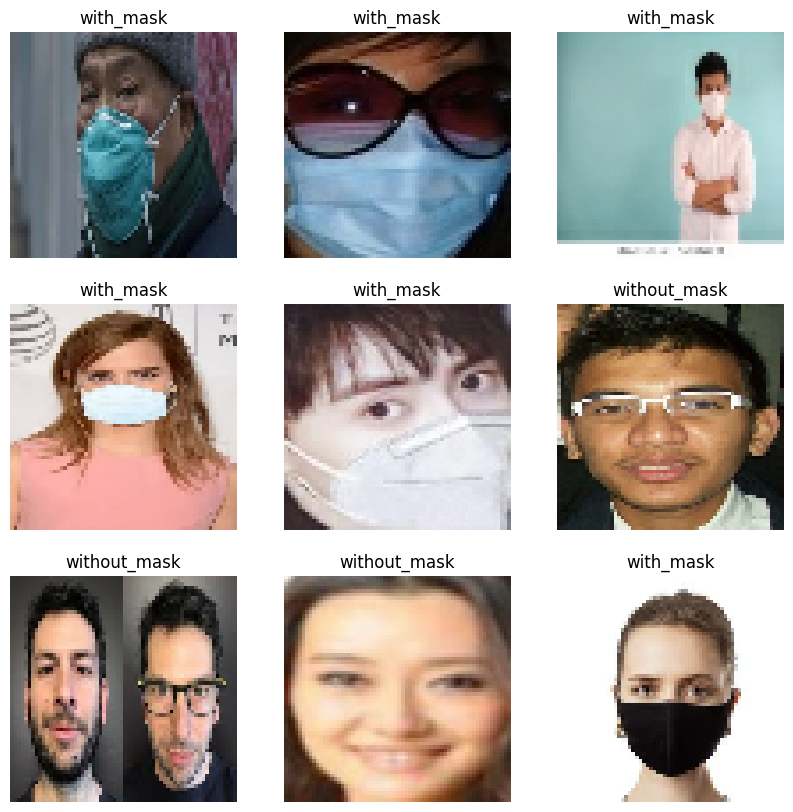

In [206]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


Now, for a better analysis, we can see the classes and predictors from our dataset

In [207]:
# Creating a function to prepare the images
def prepare_image(file, img_path=None):
    if os.path.isabs(file) or os.path.exists(file):
        img = image.load_img(file, target_size=(128, 128))
    else:
        img = image.load_img(os.path.join(img_path, file), target_size=(224, 224))

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array)

In [209]:
classes = []
for root, dirs, files in os.walk(path):
    for f in files:
        if f.lower().endswith(('.jpg','.png','.jpeg')):
            classe = os.path.basename(root)
            classes.append(classe)

counter = Counter(classes)
counter

Counter({'without_mask': 3828, 'with_mask': 3725})

Applying Pre processing with augmentation

In [210]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_train(image, label):

    image = tf.cast(image, tf.float32)
    image = data_augmentation(image)
    image = (image / 127.5) - 1
    return image, label

def preprocess_val(image, label):

    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image, label


train_dataset = train_dataset.map(preprocess_train).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_val).prefetch(AUTOTUNE)

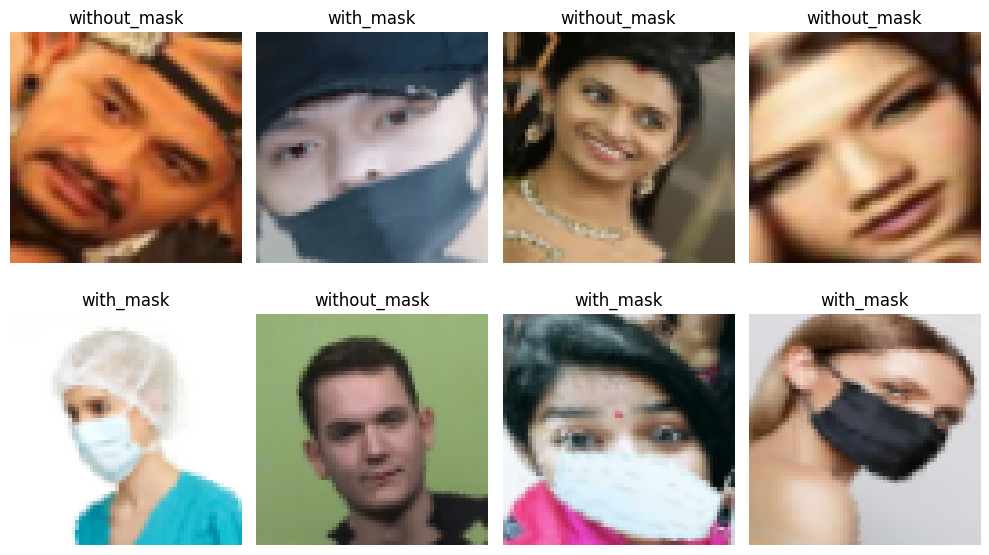

In [211]:
plt.figure(figsize=(10, 6))
for images, labels in train_dataset.take(1):
    for i in range(min(8, len(images))):
        img = (images[i] + 1) / 2
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()

Now, let's train

In [212]:
base = tf.keras.applications.MobileNet(
    input_shape=(64, 64, 3),
    alpha=0.5,
    include_top=False,
    weights="imagenet"
)


base.trainable = False


x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Strong Dropout
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)  # Dropout additional
output = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(base.input, output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

/tmp/ipython-input-772048133.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNet(


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 32, 32, 16)     │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 32, 32, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 32, 32, 16)     │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 32, 32, 32)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 16, 16, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 16, 16, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 16, 16, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 16, 16, 64)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 895,458 (3.42 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 829,536 (3.16 MB)

In [213]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

Training the top

In [214]:
print("Training only the top layers")


history_phase1 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Training only the top layers
Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - accuracy: 0.7332 - loss: 0.9415 - val_accuracy: 0.9212 - val_loss: 0.2007 - learning_rate: 0.0010
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.8423 - loss: 0.3721 - val_accuracy: 0.9325 - val_loss: 0.1849 - learning_rate: 0.0010
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.8614 - loss: 0.3123 - val_accuracy: 0.9358 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 123ms/step - accuracy: 0.8799 - loss: 0.2739 - val_accuracy: 0.9331 - val_loss: 0.1714 - learning_rate: 0.0010
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.8806 - loss: 0.2712 - val_accuracy: 0.9344 - val_loss: 0.1729 - learning_rate: 0.0010
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.8803 - loss: 0.2734 - val_accuracy: 0.9364 - val_loss: 0.1664 - learning_rate: 0.0010
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2

Fine-tuning with the basis partially thawed

In [215]:
print("Fine-tuning with the basis partially thawed")

# It only thaws the top layers of the base.
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False

# Recompiles with a MUCH lower learning rate.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # LR muito menor
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_phase2 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Fine-tuning with the basis partially thawed
Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.7711 - loss: 0.5264 - val_accuracy: 0.9086 - val_loss: 0.2230 - learning_rate: 1.0000e-05
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.8140 - loss: 0.4262 - val_accuracy: 0.9033 - val_loss: 0.2300 - learning_rate: 1.0000e-05
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 31s 162ms/step - accuracy: 0.8261 - loss: 0.3832 - val_accuracy: 0.9126 - val_loss: 0.2188 - learning_rate: 1.0000e-05
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.8392 - loss: 0.3510 - val_accuracy: 0.9152 - val_loss: 0.2062 - learning_rate: 1.0000e-05
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.8562 - loss: 0.3380 - val_accuracy: 0.9205 - val_loss: 0.1977 - learning_rate: 1.0000e-05
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.8643 - loss: 0.3058 - val_accuracy: 0.9258 - val_loss: 0.1902 - learning_rate: 1.0000e-05
Ep

Training Visualization

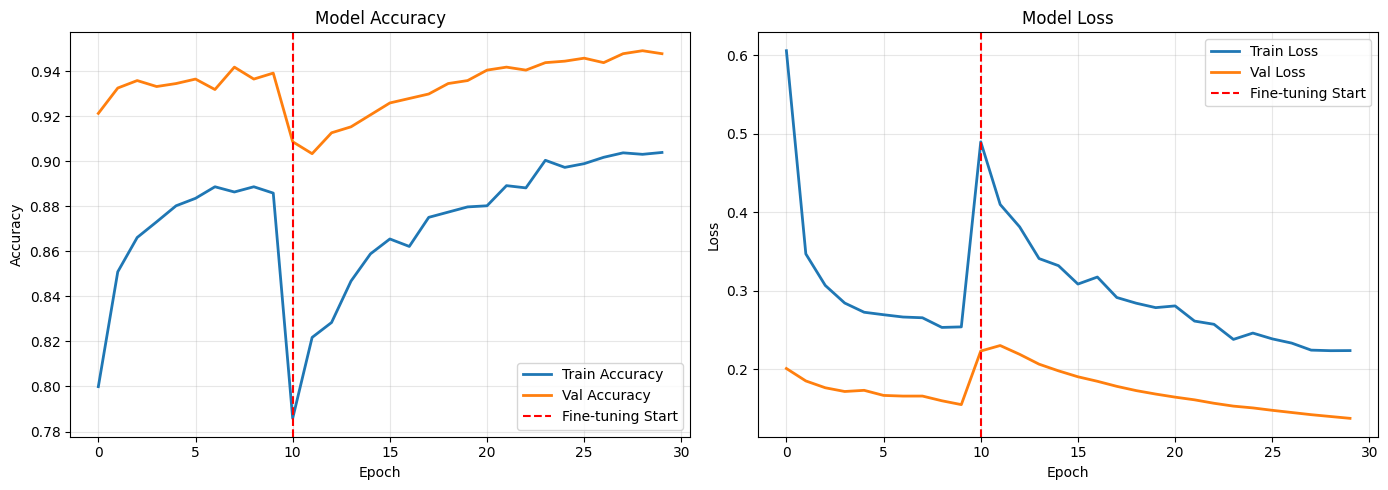

In [216]:
history_combined = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_combined['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_combined['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.axvline(x=len(history_phase1.history['accuracy']), color='r', linestyle='--', label='Fine-tuning Start')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_combined['loss'], label='Train Loss', linewidth=2)
plt.plot(history_combined['val_loss'], label='Val Loss', linewidth=2)
plt.axvline(x=len(history_phase1.history['loss']), color='r', linestyle='--', label='Fine-tuning Start')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Overfitting Diagnosis

In [219]:
final_train_acc = history_combined['accuracy'][-1]
final_val_acc = history_combined['val_accuracy'][-1]
gap = final_train_acc - final_val_acc


print("OVERFITTING DIAGNOSIS")

print(f"Train Accuracy Final: {final_train_acc*100:.2f}%")
print(f"Val Accuracy Final: {final_val_acc*100:.2f}%")
print(f"Gap (Train - Val): {gap*100:.2f}%")
if gap > 0.1:
    print("WARNING: Gap > 10% It's overfitting")
else:
    print("Gap is OK ")


OVERFITTING DIAGNOSIS
Train Accuracy Final: 90.39%
Val Accuracy Final: 94.77%
Gap (Train - Val): -4.38%
Gap is OK 


Let's test our model with another dataset

In [220]:
test_path = kagglehub.dataset_download("belsonraja/face-mask-dataset-with-and-without-mask")
print(test_path)

Using Colab cache for faster access to the 'face-mask-dataset-with-and-without-mask' dataset.
/kaggle/input/face-mask-dataset-with-and-without-mask


In [221]:
correct_test_path = os.path.join(test_path, "facemask-dataset", "dataset")
print(f"Using path: {correct_test_path}")

Using path: /kaggle/input/face-mask-dataset-with-and-without-mask/facemask-dataset/dataset


In [222]:
test_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    correct_test_path,
    image_size=(64, 64),
    batch_size=32,
    shuffle=True
)

Found 3833 files belonging to 2 classes.


In [223]:
test_class_names = test_dataset_raw.class_names
print(f"\n Test Classes: {test_class_names}")


 Test Classes: ['with_mask', 'without_mask']


In [224]:
if set(test_class_names) != set(class_names):
    print(f"WARNING: the classes are different!")
    print(f"   Train: {class_names}")
    print(f"   Test:  {test_class_names}")
else:
    print(f"The classes are compatible!")

The classes are compatible!


In [225]:
test_dataset = test_dataset_raw.map(preprocess_val).prefetch(AUTOTUNE)

In [227]:
loss, acc = model.evaluate(test_dataset)

print(f"Accuracy of the Outsider Dataset: {acc*100:.2f}%")


120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.9601 - loss: 0.1039
Accuracy of the Outsider Dataset: 96.56%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


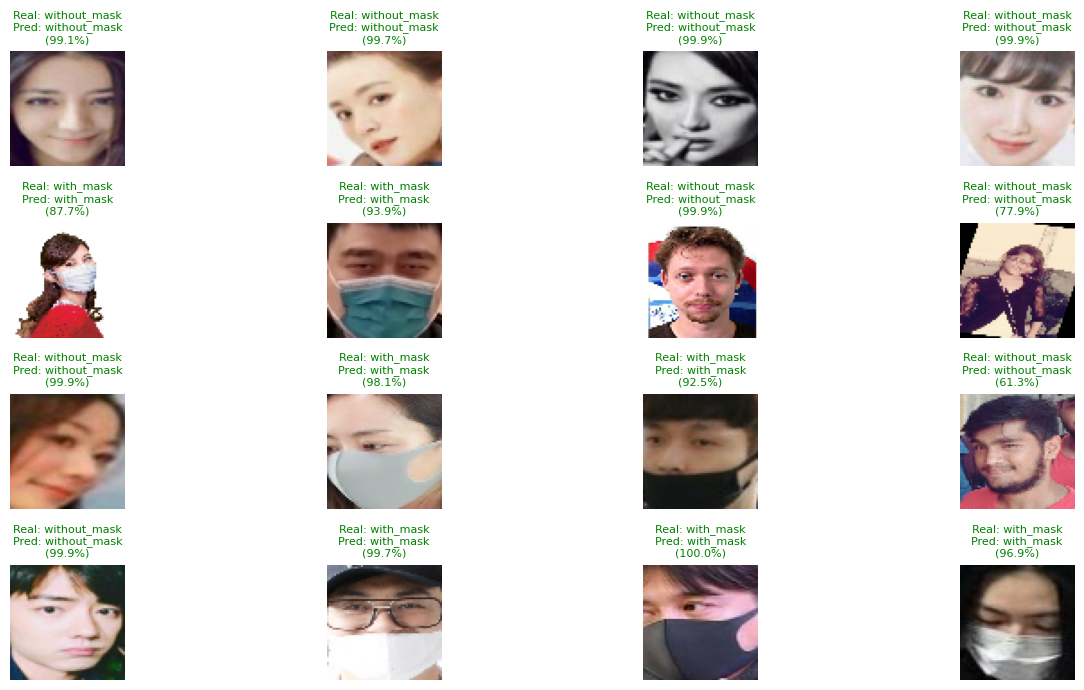

In [231]:
for images, labels in test_dataset.take(1):
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(14, 7))
    for i in range(min(16, len(images))):
        ax = plt.subplot(4, 4, i+1)


        img = (images[i].numpy() + 1) / 2
        img = np.clip(img, 0, 1)
        plt.imshow(img)

        true_label = test_class_names[labels[i]]
        pred_label = test_class_names[preds_classes[i]]
        confidence = preds[i][preds_classes[i]] * 100


        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"Real: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)",
                  fontsize=8, color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

So, the model is functional!
Now, we have to prepare it to be embedded

In [232]:
model.save("mask_detector_float.keras")

In [233]:
model.export("mask_detector_savedmodel")

Saved artifact at 'mask_detector_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_1096')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132920961807760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920973445648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920973451792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920961796240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920973444688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920961750544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920961752464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920973453136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920973455632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920961757840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132

And apply the conversion to TFLite INT8

In [234]:
def representative_data_gen():
    for images, labels in train_dataset.take(100):
        yield [images]

converter = tf.lite.TFLiteConverter.from_saved_model("mask_detector_savedmodel")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("mask_detector_int8.tflite", "wb") as f:
    f.write(tflite_model)


In [235]:
print(os.path.getsize("mask_detector_int8.tflite")/1024, "KB")

1025.1953125 KB
